# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?

---

This is a classic classification problem because we are trying to predict a binary outcome - will the student pass or fail.

---

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [415]:
# Import libraries
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import Normalizer
from sklearn.metrics import f1_score, make_scorer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"
# Note: The last column 'passed' is the target/label, all other are feature columns

Student data read successfully!


Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [3]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_students = student_data.shape[0]
n_features = student_data.shape[1]
n_passed = student_data['passed'].value_counts().loc['yes']
n_failed = student_data['passed'].value_counts().loc['no']
grad_rate = n_passed / float(n_passed + n_failed)
print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 31
Graduation rate of the class: 0.67%


## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [4]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print "\nFeature values:-"
print X_all.head()  # print the first 5 rows

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...    

### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [5]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we'll split the data (both features and corresponding labels) into training and test sets.

In [7]:
from sklearn.cross_validation import StratifiedShuffleSplit

# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train

We'll use sklearn's  [StratifiedShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html#sklearn.cross_validation.StratifiedShuffleSplit) to split our data.

A stratified split will ensure that we get a similar distribution of the target variable, 'passed', in both the training and testing sets.

This should be useful if our target y variable is highly unevenly distributed. It should also be slightly helpful in our case of having the contraint of a fairly small training/testing dataset since a 'bad' split with very little variety in the test set could cause poor estimates of model performance.

---

We should also explore the data a little bit to get a feel for the data. We'll also set the seed to make the analysis reproducible. 

We can use the same indices to split the original dataset which didn't contain the dummy variables. This is because we can more easily explore the original training set with plotting libraries.

---

In [8]:
# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset
splitGenerator = StratifiedShuffleSplit(y=y_all, 
                                        n_iter=1,
                                        train_size=num_train,
                                        test_size=num_test,
                                        random_state=1337)

# Retrieve the next (and only) train/test set indices from the generator.
train_index, test_index = next(iter(splitGenerator))

X_train = X_all.iloc[train_index] 
y_train = y_all.iloc[train_index]
X_test = X_all.iloc[test_index]
y_test = y_all.iloc[test_index]

print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

# Grab the same training rows from the original set for exploring.
X_train_explore = student_data.iloc[train_index]

Training set: 300 samples
Test set: 95 samples


## 2.1 Exploring the Data - Revisited 

Now that we have a testing split pulled out and locked away in vault, let's get a feel for the training data.

We don't want to go exploring the full dataset and risk peeking at our test data and influencing our model selections using any of the test data.

Although note: the training and test data should be distributed roughly the same anyway if we assume they are independent and identically distributed (i.i.d.) and split at random.

It should also be noted that we are not attempting to draw any conclusions about the data, but instead just get a feel for the data. 

In [9]:
import string
from student_intervention_utils import feature_full_names

# Import a helper dictionary mapping a column name to a better description (from the readme.md)
# Use the string library to capitalize words, and deal with apostrophe's
feature_full_names = {key: string.capwords(value) for key, value in feature_full_names.iteritems()}

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

#plt.style.use('bmh')
%matplotlib inline

/home/fch/GPU_2.7/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


---

Here, we can plot the counts of the different categorical variables, factored by whether the student passed or not.

---

In [11]:
def plot_counts_categorical(df, count_col='passed', plots_per_row=3):
    
    # Grab all object-type data only
    df_cat = df.select_dtypes(include=['object'])
    
    # Add in the count_col column in case it wasn't included.
    if not (count_col in df_cat.columns):
        df_cat.join(df[count_col])

    for i, col in enumerate(df_cat.columns):
        # Create an index # for each plot. Depends on how many are needed per row.
        plot_index = i % plots_per_row
        
        # If it's the first plot in the row, start a new plot.
        if plot_index == 0:
            f, axes = plt.subplots(1, plots_per_row, figsize=(18, 5))
            sns.despine(left=True)
        
        # Add a countplot to the proper index in plot.
        sns.countplot(data=df, x=col, hue=count_col, ax=axes[plot_index])
        
        # Change the title if it's just a count of one variable, or factored by a second varaible.
        if count_col != col:
            plot_title='Counts of "{0}" \nfactored by "{1}"'.format(feature_full_names[col],
                                                                    feature_full_names[count_col])
        else:
            plot_title = 'Counts of "{0}"'.format(feature_full_names[count_col])
        axes[plot_index].set_title(plot_title)

/home/fch/GPU_2.7/local/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


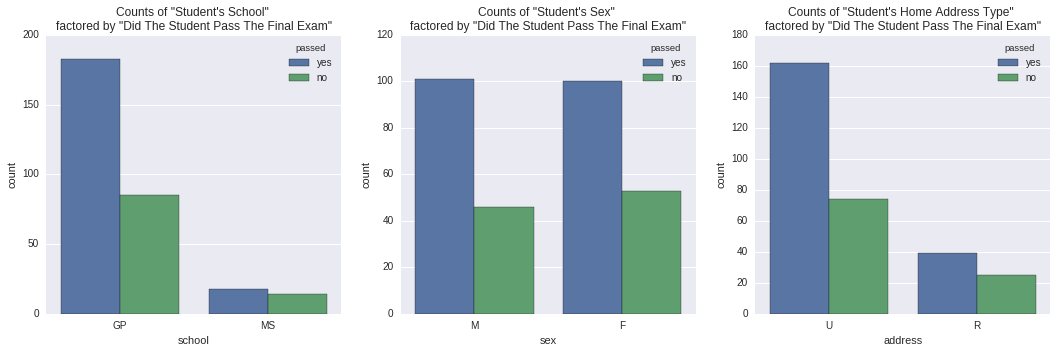

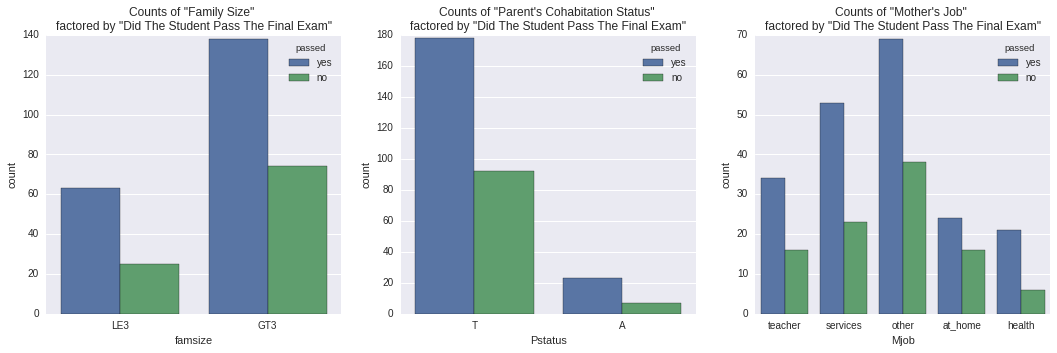

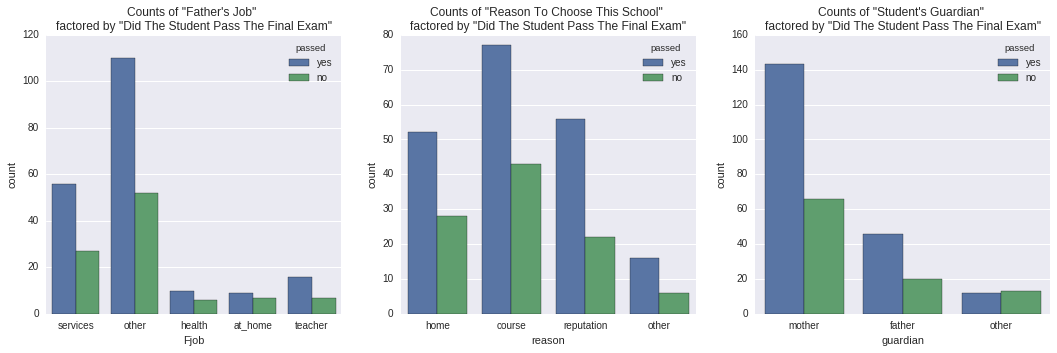

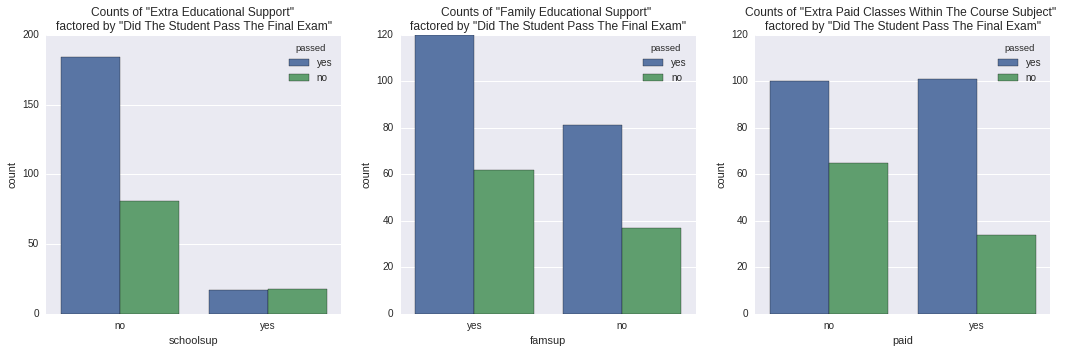

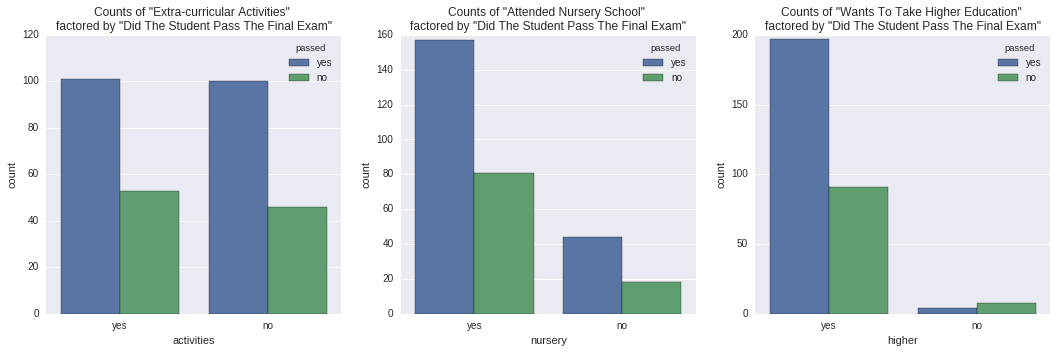

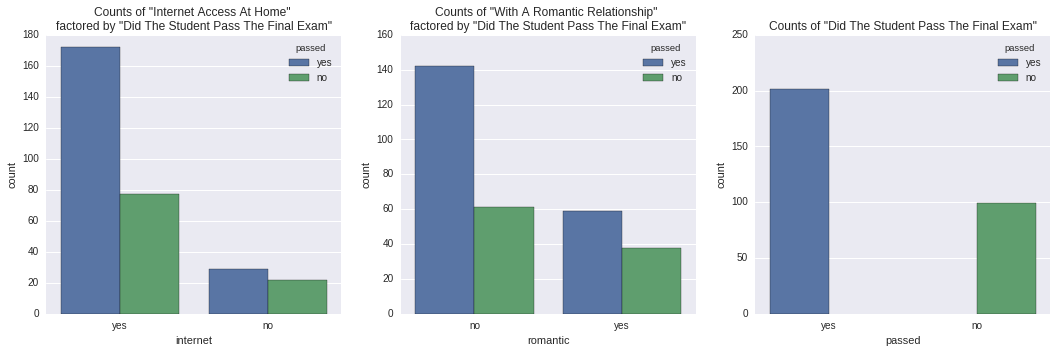

In [12]:
plot_counts_categorical(X_train_explore, count_col='passed', plots_per_row=3)

In most cases, there were not enough students in all of the choices available for each category to draw any meaningful conclusions.

Some distributions did show that there might be differences.

- "Internet access at home"

Those who had access to internet at home, had about twice as many students pass, while those without internet access were fairly close in counts of pass vs fail.

- "With a romantic relationship"

Those not in a romantic relationship seemed to pass relatively more frequently than those in relationships.

"Extra Education Support", "Student's School", and "Wants to take higher education" also showed hints of differing distributions depending on answers, but again, the number of students in each answer were too low to draw any conclusions by eye. 

And again, we are not drawing any conclusions, but perhaps a decision tree clasifier might fair well if pass/fail distributions are different depending on answers to some questions.

Next, let's take at the distriutions of the more continuous numeric variables.

In [13]:
def plot_discrete_numeric_data(df, factor_col='passed', plots_per_row=3):
    
    # Grab all object data only
    df_cat = df.select_dtypes(exclude=['object'])
    
    # Add in the count_col column in case it wasn't included.
    if not (factor_col in df_cat.columns):
        df_cat = df_cat.join(df[factor_col])
    
    # Get rid of the distracting grid; just getting a feel 
    #  for the distributions of pass/fail for each feature.
    sns.set(style="white")
    
    
    for i, col in enumerate(df_cat.columns):
        if col == factor_col:
            continue
        # Create an index # for each plot. Depends on how many are needed per row.
        plot_index = i % plots_per_row
        
        # If it's the first plot in the row, start a new plot.
        if plot_index == 0:
            f, axes = plt.subplots(1, plots_per_row, figsize=(18, 5), sharey=False)
            sns.despine(left=True)
        

        # Separate data into two dataframe, those who passed and those who didn't
        pass_yes = df_cat.loc[df_cat[factor_col] == "yes"]
        yes_label = '{0} - Passed'.format(feature_full_names[col])
        
        pass_no = df_cat.loc[df_cat[factor_col] == "no"]
        no_label = '{0} - Failed'.format(feature_full_names[col])

        # Plot each kernel density plot and overlay them.
        sns.kdeplot(pass_yes[col],
                    ax=axes[plot_index], 
                    shade=True,
                    label=yes_label, 
                    color='#32cd33').set(xlim=(min(pass_no[col]))) # Limit the x-label to the min.
        
        sns.kdeplot(pass_no[col],
                    ax=axes[plot_index], 
                    shade=True, 
                    label=no_label,
                    color='#cd3332').set(xlim=(min(pass_no[col])))   
        
        # Remove y-axes; just getting a feel for the distributions of pass/fail for each feature.
        plt.setp(axes, yticks=[])
        
        # Change the title if it's just a count of one variable, or factored by a second varaible.

        plot_title='Distribution of "{0}" \nfactored by "{1}"'.format(feature_full_names[col],
                                                                feature_full_names[factor_col])

        axes[plot_index].set_title(plot_title)

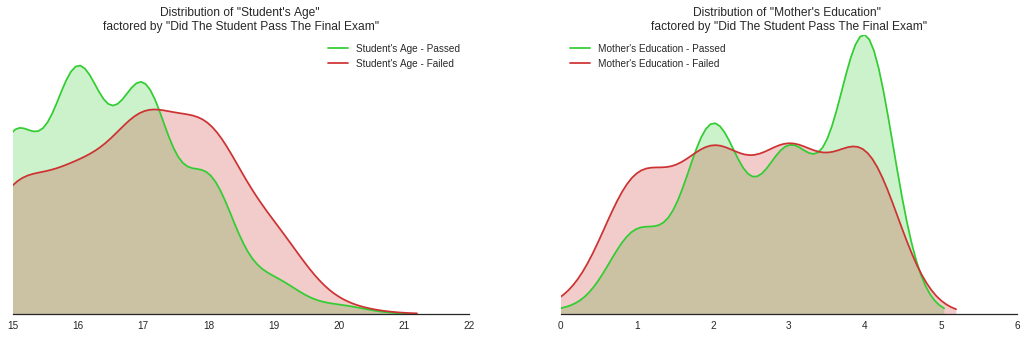

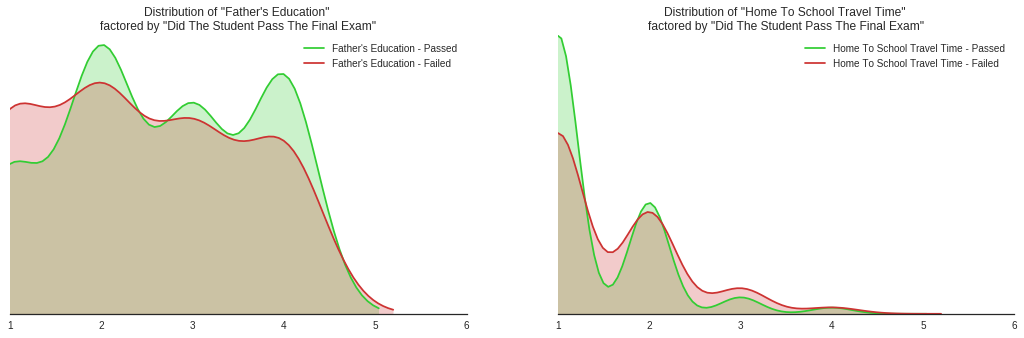

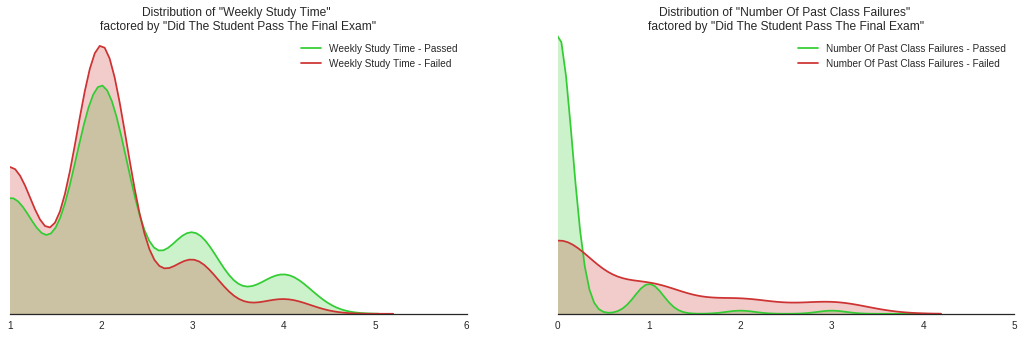

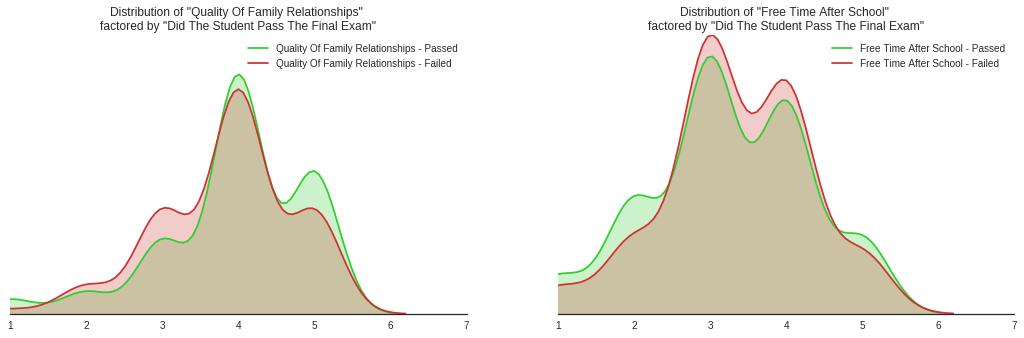

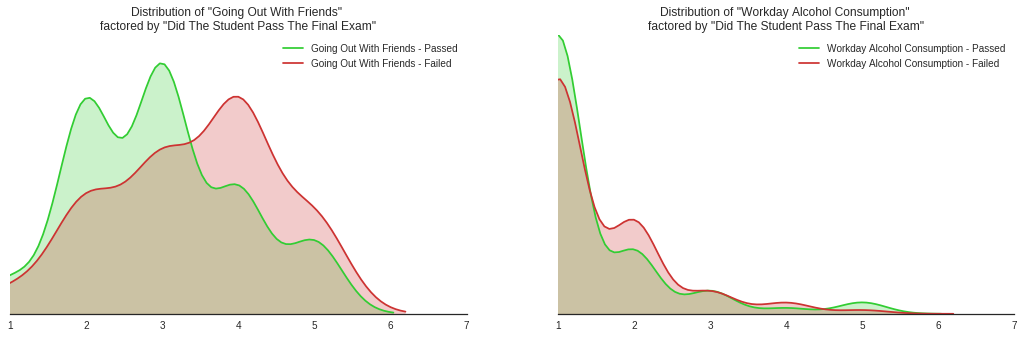

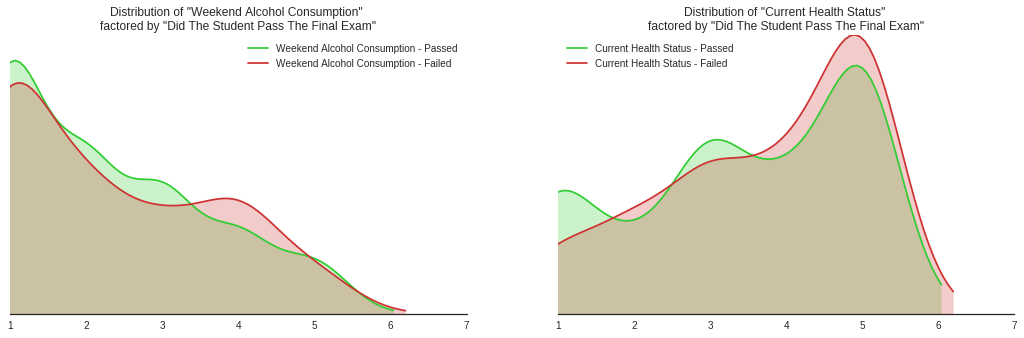

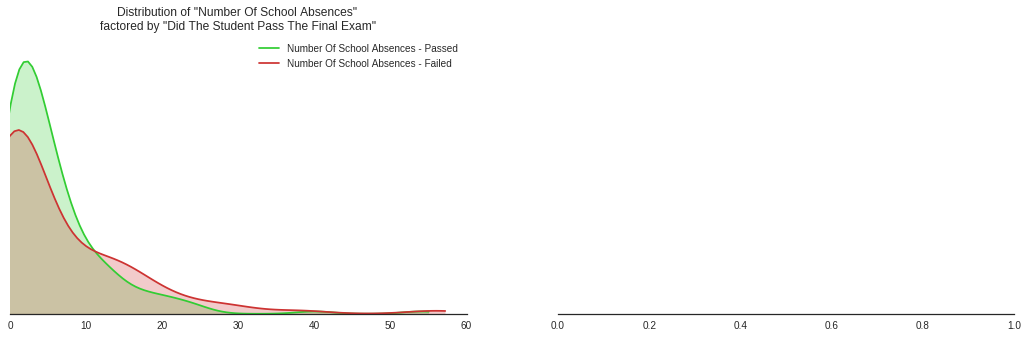

In [14]:
plot_discrete_numeric_data(X_train_explore, factor_col='passed', plots_per_row=2)

Here we can see the estimated probability distributions. A couple stand out as being possibly different for students who passed vs failed.

- "Number of past failures"

Of those students who passed, there was a very high probability of having 0 past failures. But of those failed, there was a more even distribution of probable values between 0-4 times. This is looks to potentially be large indicator of failing.

- "Going out with friends"

Passing students peaked around 2-3 times a week, while the probability mass of failing students centered around 4 times a week.

Again, we can't draw any conclusions, but this also hints at including a decision tree (or nearest-neighbor) based machine learning algorithm for splitting the data based on variables. 

This would have the added benefit of giving some actionable variables to focus on when attempting to improve passing rate, something that a more opaque machine learning model like a neural net or support vector machine may not be able to provide.

## 4. Training and Evaluating Models
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- ~~_What is the theoretical O(n) time & space complexity in terms of input size?_~~
- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

---

For this particular case, I'd argue that maximum prediction accuracy is not our most important goal, but rather inference with high prediction accuracy. 

If we are simply trying to measure how well a school's changes are doing, pure prediction accuracy maximization might be the goal.

But I'd argue that in this case, we are also trying to provide some actionable items to address to possibly increase passing rate. In this case, I'd recommend more transparent supervised learning models.

This would include the simplest to intepret, a Decision Tree.

It would also include a more robust RandomForest, with feature importance as a measure of important actionable variables. 

A third might be logistic regression with an L1 regularizer to perform a sort of feature selection and keeping only the most important variables in the model.

---

SVM or neural networks might deliver high accuracy as well, but we would only be measuring the prediction accuracy of a given set of measured variables with no idea of what to address to possibly increase the passing rate of future students.

---


- ~~_TODO: Add $O(n)$ of models and search spaces._~~
- ~~_What is the theoretical O(n) time & space complexity in terms of input size?_~~


---

- TODO: What are the general applications of this model? What are its strengths and weaknesses?

- TODO: Given what you know about the data so far, why did you choose this model to apply?

---

- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

---

For now, our training set is small enough that we might be forgiven for foregoing a validation set and using K-fold cross-validation in its place.

---

TODO: Add K-fold stuff here.

In [562]:
# Train a model
import time

def train_classifier(clf, X_train, y_train, verbose=True):
    
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    train_time = end - start
    
    if verbose:
        print "Trained {}...".format(clf.__class__.__name__)
        print "Training time (secs): {:.4f}".format(train_time)

    return clf, train_time

In [563]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score

def predict_labels(clf, features, target, verbose=True):
    
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    
    prediction_time = end - start
    
    if verbose:
        print "Predicted labels using {}...".format(clf.__class__.__name__)
        print "Prediction time (secs): {:.4f}".format(prediction_time)

    return f1_score(target.values, y_pred, pos_label='yes'), prediction_time


In [564]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test, verbose=True):

    clf, train_time = train_classifier(clf, X_train, y_train, verbose=verbose)
    
    F1_train, prediction_time_train = predict_labels(clf, X_train, y_train, verbose=verbose)
    
    F1_test, prediction_time_test = predict_labels(clf, X_test, y_test, verbose=verbose)
    
    if verbose:
        print "------------------------------------------"
        print "Training set size: {}".format(len(X_train))    
        print "F1 score for training set: {}".format(F1_train)
        print "F1 score for test set: {}".format(F1_test)
    
    F1_scores = {'F1_train': F1_train,
                 'F1_test': F1_test}
    
    timings = {'Training_time': train_time,
               'Predict_time_train': prediction_time_train,
               'Predict_time_test': prediction_time_test}
    
    return clf, F1_scores, timings
# TODO: Run the helper function above for desired subsets of training data
# Note: Keep the test set constant

In [853]:
def subset_train_predict(clf, X_train, y_train, X_test, y_test, subset_sizes, verbose=False):
    # http://stackoverflow.com/questions/10715965/add-one-row-in-a-pandas-dataframe

    rows_list = [] # Ininitialize an empty list to hold each row of data for the dataframe

    for i in subset_sizes:
        one_row = {'Training_size': i} # Initialize new row each pass 
        
        X_train_subset = X_train[:i]
        y_train_subset = y_train[:i]
        
        clf, F1_scores, timings = train_predict(clf, X_train_subset, y_train_subset, X_test, y_test, verbose=verbose)
        
        one_row.update(F1_scores) # Update row dictionary with our data
        one_row.update(timings)
        
        rows_list.append(one_row) # Add each row to the list of rows
        
    # Create/return a pandas dataframe with the list of rows 
    # (uses a list comprehension under the hood for speed)
    return pd.DataFrame(rows_list) 

In [854]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.
    
    Args
    ----
    tree -- scikit-learn DecisionTree model.
    feature_names -- list of feature names.
    """
    with open("tree.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        impurity=False,
                        rounded=True,
                        filled=True,
                        leaves_parallel=False,
                        feature_names=feature_names,
                        class_names=['fail', 'pass']) # Corresponds to our [0, 1] y-variables

In [855]:
def computation_time_plot(comp_stat_df):

    fig, ax = plt.subplots(figsize=(12, 9))
    ax.plot(comp_stat_df.Training_size, comp_stat_df.Predict_time_test, label='Prediction Time - Test')
    ax.plot(comp_stat_df.Training_size, comp_stat_df.Predict_time_train, '--', label='Prediction Time - Train')
    ax.plot(comp_stat_df.Training_size, comp_stat_df.Training_time, label='Training Time')    
    legend = ax.legend(loc='best')
    ax.set_xticks(subset_sizes)
    ax.set_xticklabels(subset_sizes, rotation='vertical')
    ax.set_ylabel('Seconds')
    ax.set_xlabel('Training Set Size')
    ax.set_title('Training/Prediction Times')
    plt.show()

In [856]:
def F1_plot(comp_stat_df):

    fig, ax = plt.subplots(figsize=(12, 9))
    ax.plot(comp_stat_df.Training_size, comp_stat_df.F1_test, label='F1 score - Test')
    ax.plot(comp_stat_df.Training_size, comp_stat_df.F1_train, '--', label='F1 score - Train')
    legend = ax.legend(loc='best')
    ax.set_ybound(min(comp_stat_df.F1_test) - 0.05, max(comp_stat_df.F1_train) + 0.05)
    ax.set_xticks(subset_sizes)
    ax.set_xticklabels(subset_sizes, rotation='vertical')
    ax.set_ylabel('F1 Score')
    ax.set_xlabel('Training Set Size')
    ax.set_title('F1 Scores for each sample size training set')
    plt.show()

In [857]:
subset_sizes = xrange(100, 301, 10)

computation_stats = subset_train_predict(DecisionTreeClassifier(),
                                         X_train, y_train,
                                         X_test, y_test,
                                         subset_sizes=subset_sizes)

computation_stats

,F1_test,F1_train,Predict_time_test,Predict_time_train,Training_size,Training_time
0,0.728682,1,0.000112,0.000115,100,0.000623
1,0.777778,1,0.000105,0.000118,110,0.000620
2,0.697674,1,0.000101,0.000114,120,0.000732
3,0.761905,1,0.000107,0.000123,130,0.000711
4,0.802920,1,0.000106,0.000113,140,0.000662
5,0.729927,1,0.000104,0.000125,150,0.000721
6,0.732824,1,0.000102,0.000117,160,0.000760
7,0.757143,1,0.000101,0.000113,170,0.000736
8,0.735294,1,0.000100,0.000121,180,0.000985
9,0.777778,1,0.000103,0.000116,190,0.000821


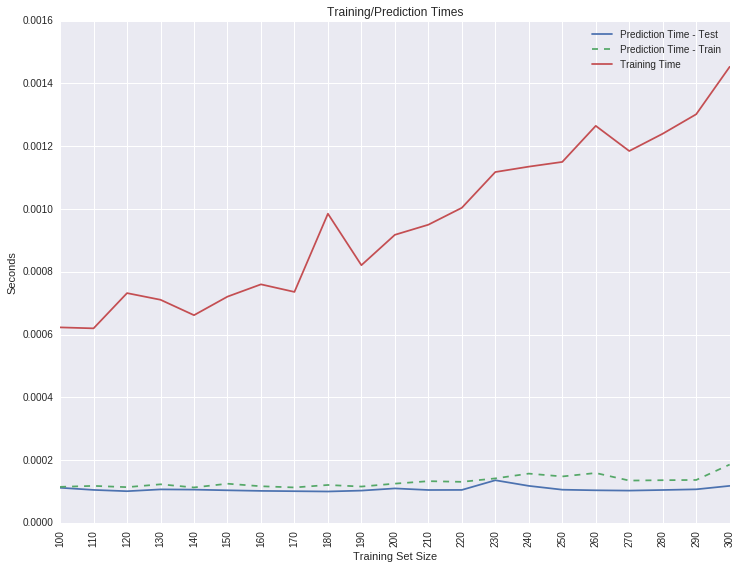

In [858]:
computation_time_plot(computation_stats)

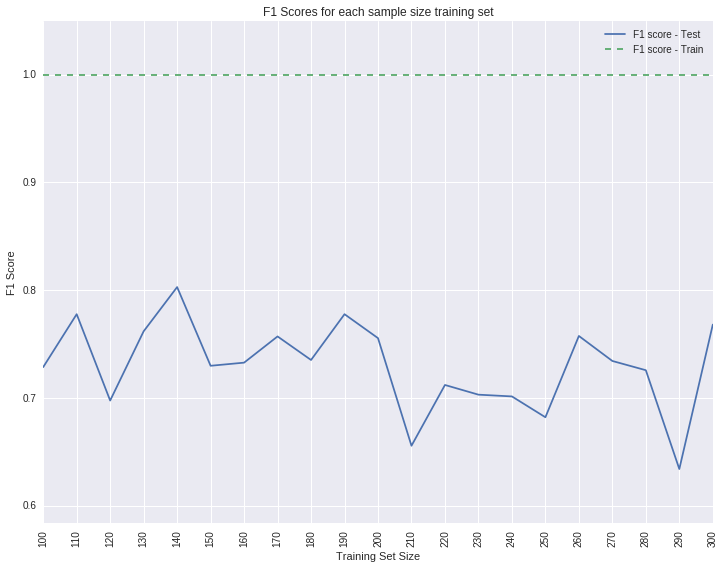

In [859]:
F1_plot(computation_stats)

In [860]:
# Choose a model, import it and instantiate an object

tree_model, _, _ = train_predict(DecisionTreeClassifier(),
                                 X_train,
                                 y_train,
                                 X_test, 
                                 y_test)

Trained DecisionTreeClassifier...
Training time (secs): 0.0016
Predicted labels using DecisionTreeClassifier...
Prediction time (secs): 0.0002
Predicted labels using DecisionTreeClassifier...
Prediction time (secs): 0.0001
------------------------------------------
Training set size: 300
F1 score for training set: 1.0
F1 score for test set: 0.757575757576


In [861]:
visualize_tree(tree_model, X_train.columns)


In [862]:
%%bash

dot -Tpng tree.dot -o tree.png

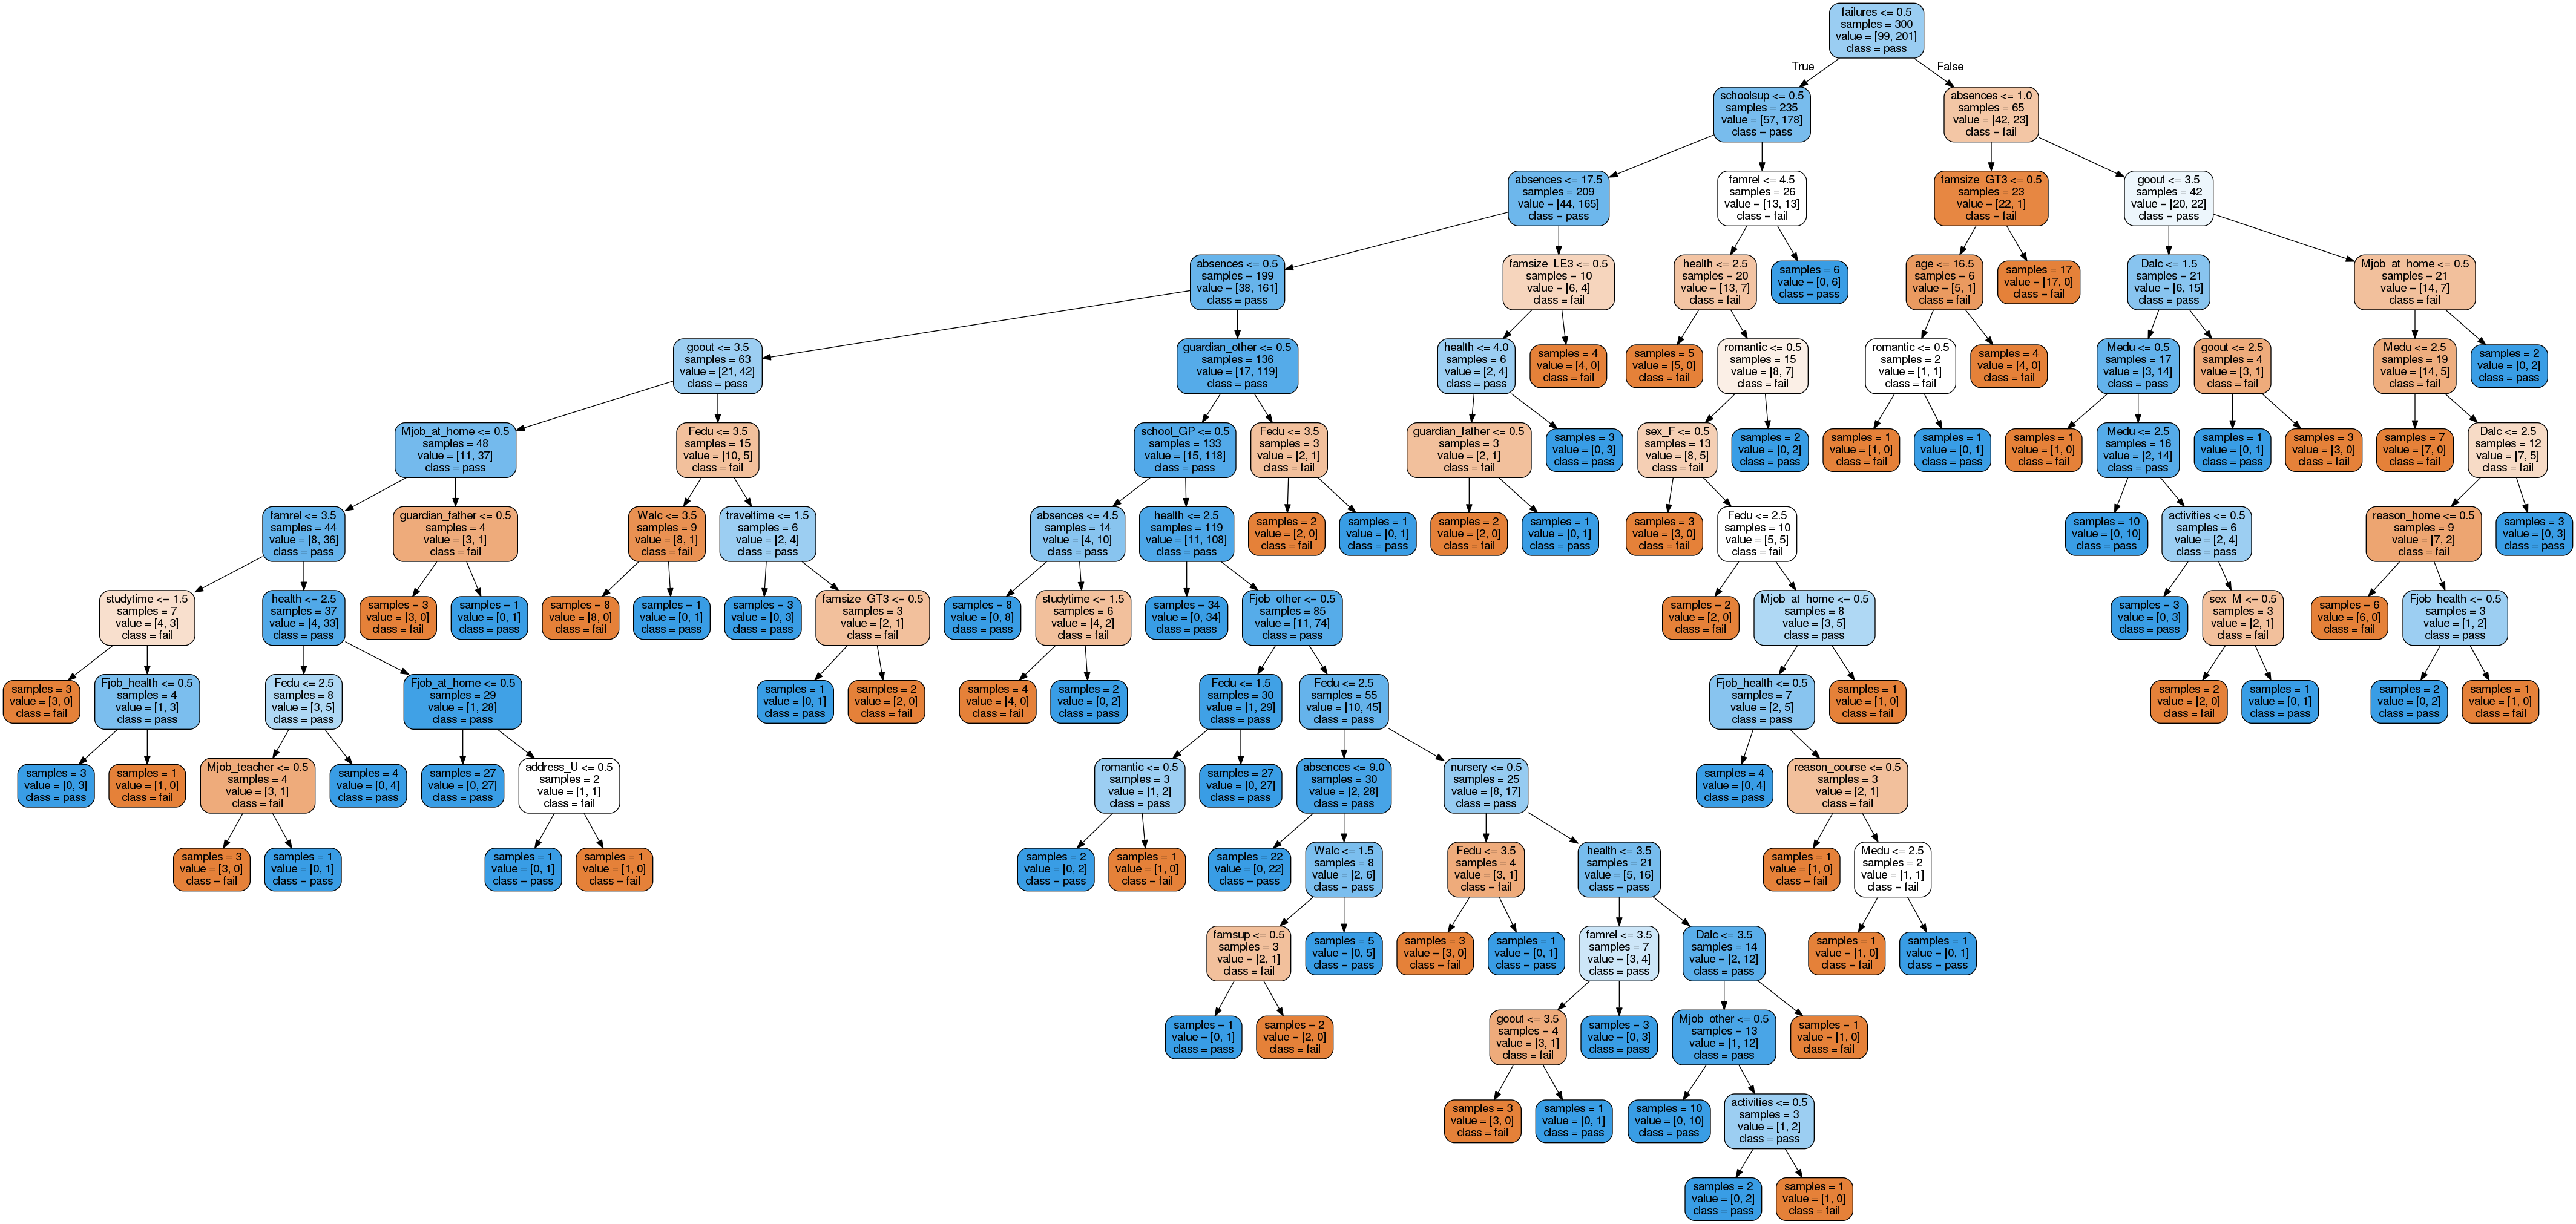

In [863]:
from IPython.display import Image
Image(filename='tree.png', width=920, height=1280)

In [864]:
subset_sizes = xrange(100, 301, 10)

computation_stats = subset_train_predict(RandomForestClassifier(),
                                         X_train, y_train,
                                         X_test, y_test,
                                         subset_sizes=subset_sizes)
computation_stats

,F1_test,F1_train,Predict_time_test,Predict_time_train,Training_size,Training_time
0,0.696970,1.000000,0.000644,0.000681,100,0.013327
1,0.736842,1.000000,0.000656,0.000726,110,0.011506
2,0.776978,0.981595,0.000704,0.000695,120,0.011193
3,0.770370,0.988506,0.000695,0.000808,130,0.011968
4,0.762590,0.994595,0.000664,0.000753,140,0.011758
5,0.836879,0.990196,0.000616,0.000700,150,0.012108
6,0.788321,1.000000,0.000600,0.000673,160,0.010552
7,0.776978,0.991379,0.000570,0.000652,170,0.010500
8,0.751880,0.995816,0.000611,0.000717,180,0.010708
9,0.736842,1.000000,0.000581,0.000676,190,0.010740


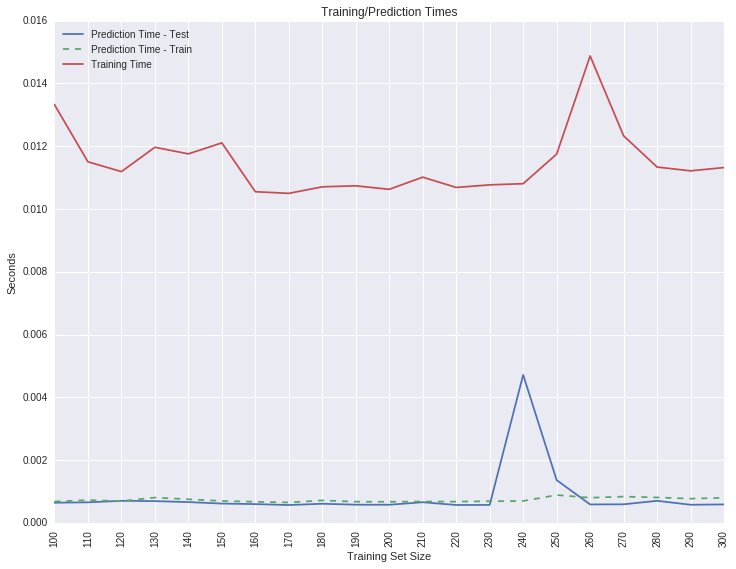

In [865]:
computation_time_plot(computation_stats)

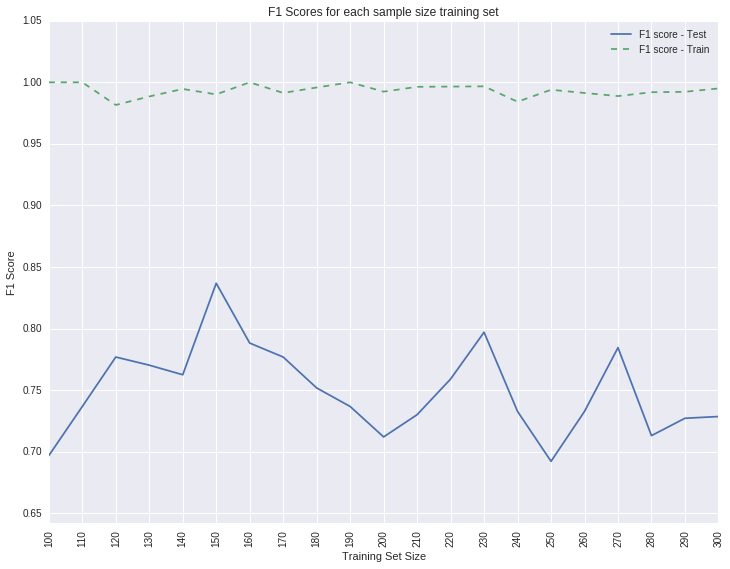

In [866]:
F1_plot(computation_stats)

In [867]:
rf_model, _, _ = train_predict(RandomForestClassifier(), X_train, y_train, X_test, y_test)


Trained RandomForestClassifier...
Training time (secs): 0.0134
Predicted labels using RandomForestClassifier...
Prediction time (secs): 0.0009
Predicted labels using RandomForestClassifier...
Prediction time (secs): 0.0007
------------------------------------------
Training set size: 300
F1 score for training set: 0.997506234414
F1 score for test set: 0.742424242424


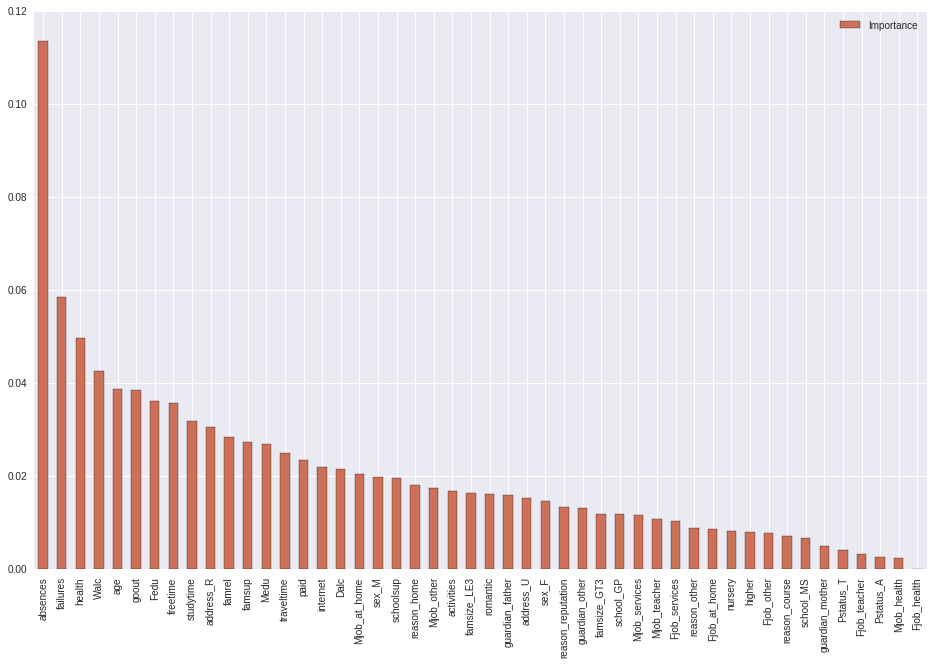

In [868]:
rf_importances = pd.DataFrame({'Feature': X_train.columns, 
                               'Importance': rf_model.feature_importances_}, 
                             index=X_train.columns)

rf_importances.sort_values(by='Importance',
                           ascending=False).plot(kind='bar', 
                                                 figsize=(16, 10),
                                                 color='#cd7058')

---

In [869]:
normalizer = Normalizer().fit(X_train)
X_train_normed = normalizer.transform(X_train)
X_test_normed = normalizer.transform(X_test)

lr_model, _, _ = train_predict(LogisticRegression(penalty='l1'),
                               X_train_normed, y_train, X_test_normed, y_test)

Trained LogisticRegression...
Training time (secs): 0.0013
Predicted labels using LogisticRegression...
Prediction time (secs): 0.0065
Predicted labels using LogisticRegression...
Prediction time (secs): 0.0001
------------------------------------------
Training set size: 300
F1 score for training set: 0.823284823285
F1 score for test set: 0.802631578947


---

In [877]:
subset_sizes = xrange(100, 301, 10)

computation_stats = subset_train_predict(LogisticRegression(),
                                         X_train, y_train,
                                         X_test, y_test,
                                         subset_sizes=subset_sizes)
computation_stats

,F1_test,F1_train,Predict_time_test,Predict_time_train,Training_size,Training_time
0,0.847222,0.895105,0.000652,0.006589,100,0.001110
1,0.845070,0.896104,0.000630,0.001770,110,0.000897
2,0.828571,0.875740,0.000677,0.001992,120,0.000851
3,0.828571,0.865169,0.000604,0.001192,130,0.001664
4,0.842857,0.857143,0.000574,0.001797,140,0.001021
5,0.845070,0.831776,0.000588,0.001775,150,0.001023
6,0.836879,0.835443,0.000607,0.001034,160,0.002139
7,0.825175,0.820717,0.000704,0.006195,170,0.001564
8,0.808511,0.828125,0.000120,0.001948,180,0.001455
9,0.834532,0.839416,0.000102,0.000130,190,0.001391


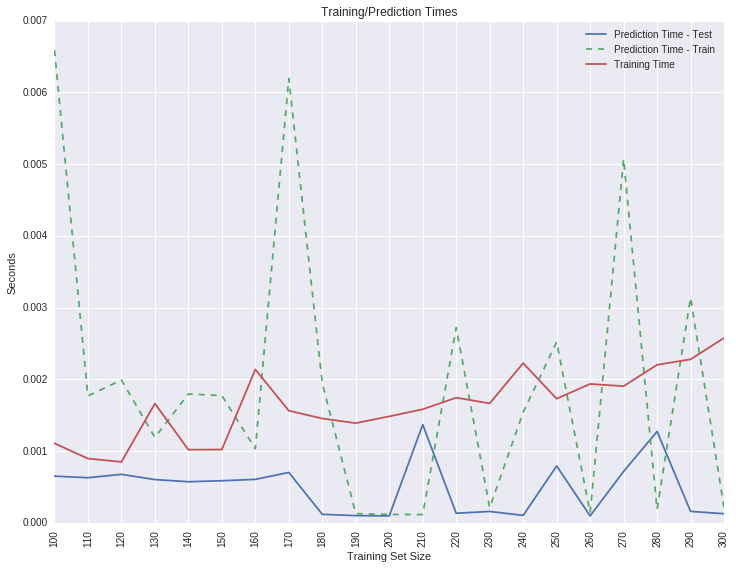

In [878]:
computation_time_plot(computation_stats)

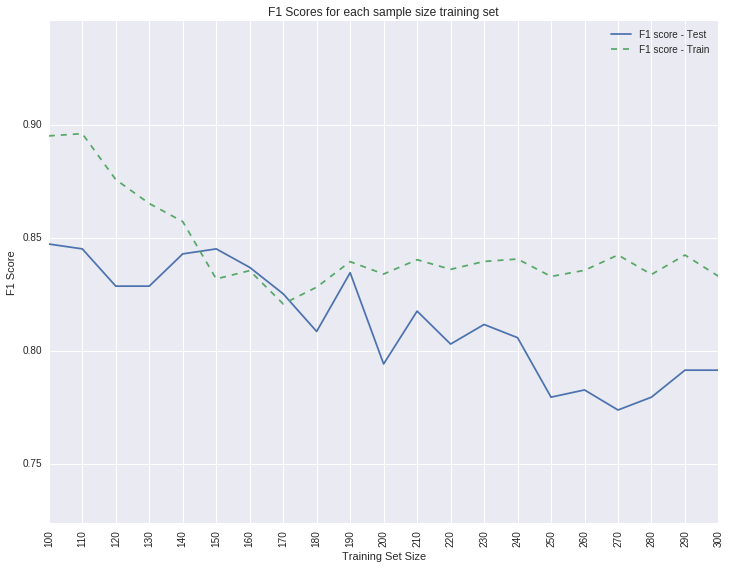

In [872]:
F1_plot(computation_stats)

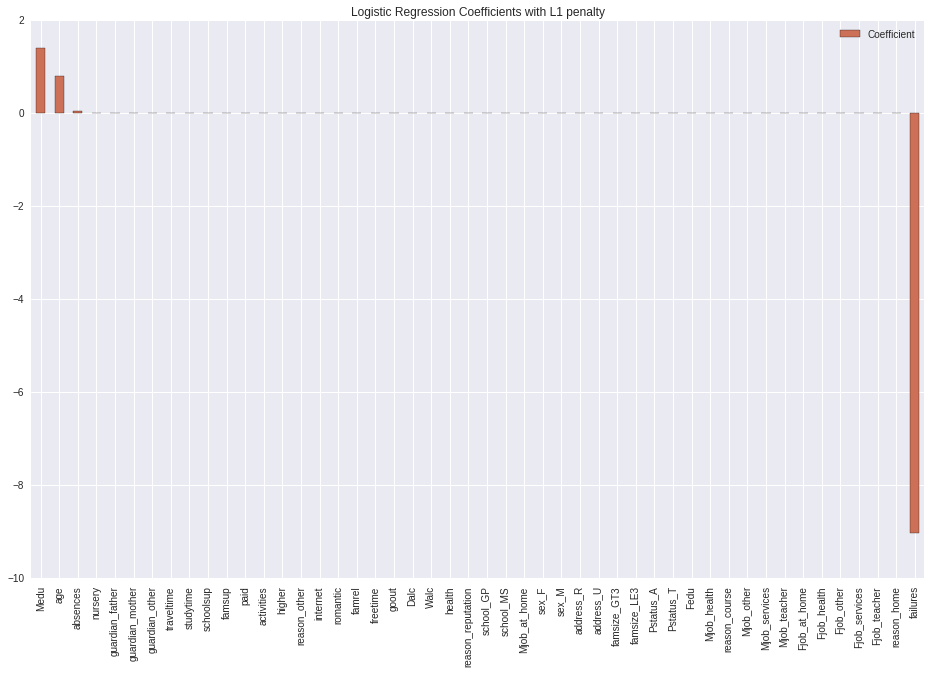

In [873]:
lr_coeff = pd.DataFrame({'Feature': X_train.columns, 
                         'Weight': rf_model.feature_importances_}, 
                         index=X_train.columns)

lr_coeffs = pd.DataFrame({'Feature': X_train.columns, 
                          'Coefficient': lr_model.coef_[0]}, 
                             index=X_train.columns)

lr_coeffs.sort_values(by='Coefficient', 
                      ascending=False).plot(kind='bar',
                                            figsize=(16, 10),
                                            color='#cd7058',
                                            title='Logistic Regression Coefficients with L1 penalty')

In [529]:
print lr_coeffs.sort_values(by='Coefficient', 
                            ascending=False).head(4)
print '-'*80

print lr_coeffs.sort_values(by='Coefficient', 
                            ascending=False).tail(4)

          Coefficient   Feature
Medu         1.401637      Medu
age          0.810505       age
absences     0.055807  absences
nursery      0.000000   nursery
--------------------------------------------------------------------------------
               Coefficient        Feature
Fjob_services     0.000000  Fjob_services
Fjob_teacher      0.000000   Fjob_teacher
reason_home       0.000000    reason_home
failures         -9.014722       failures


In [530]:
train_predict(LogisticRegression(penalty='l1'),
              X_train[['Medu', 'age', 'absences', 'failures']],
              y_train,
              X_test[['Medu', 'age', 'absences', 'failures']],
              y_test)

------------------------------------------
Training set size: 300
Training LogisticRegression...
Done!
Training time (secs): 0.002
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.815964523282
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.816326530612


(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 {'F1_test': 0.81632653061224481, 'F1_train': 0.81596452328159641},
 {'Predict_test': 7.891654968261719e-05,
  'Predict_train': 0.00010514259338378906,
  'Training': 0.0016329288482666016})

## 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F<sub>1</sub> score?

In [422]:
# TODO: Fine-tune your model and report the best F1 score

In [423]:

# from sklearn.preprocessing import label_binarize

In [424]:
labeled_f1_scorer = make_scorer(f1_score, pos_label='yes')

In [479]:
tree_params = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_features': ['auto', 'sqrt', 2, 3, 5, 10, 15],
              'max_depth': [None, 2, 3, 4, 5, 8],
              'min_samples_split': [2, 10, 30, 60]
              }

In [480]:
tree_grid_search = GridSearchCV(estimator=DecisionTreeClassifier(),
                                param_grid=tree_params,
                                scoring=labeled_f1_scorer,
                                cv=5,
                                n_jobs=-1, # Use max amount of CPU cores available with -1,
                                verbose=1)

In [481]:
tree_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 672 candidates, totalling 3360 fits


[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 3360 out of 3360 | elapsed:    2.9s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': ['auto', 'sqrt', 2, 3, 5, 10, 15], 'splitter': ['best', 'random'], 'min_samples_split': [2, 10, 30, 60], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 2, 3, 4, 5, 8]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(f1_score, pos_label=yes), verbose=1)

In [482]:
tree_grid_search.best_score_

0.82260724982538236

In [483]:
tree_grid_search.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=10, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [484]:
tree_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'max_features': 10,
 'min_samples_split': 2,
 'splitter': 'best'}

In [485]:
visualize_tree(tree_grid_search.best_estimator_, X_train.columns)

In [486]:
%%bash

dot -Tpng tree.dot -o tree.png

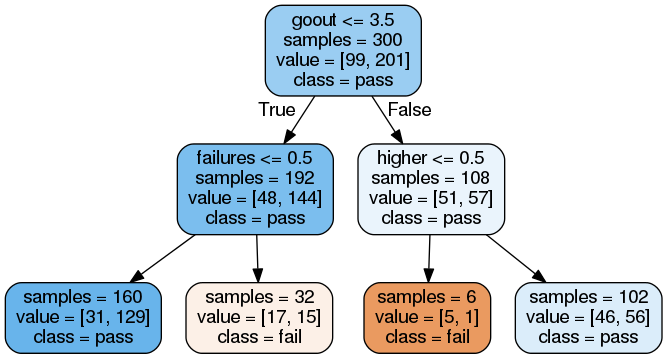

In [487]:
from IPython.display import Image
Image(filename='tree.png', width=920, height=1280)

In [488]:
train_predict(DecisionTreeClassifier(**tree_grid_search.best_params_),
              X_train,
              y_train,
              X_test,
              y_test)

------------------------------------------
Training set size: 300
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.001
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.816513761468
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.794326241135


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=10, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

---

In [360]:
rf_params = {'criterion': ['gini', 'entropy'], # Default: 'gini'
              'max_features': ['auto', 3, 5, 10, 15, 20, 25], # Default: “auto” - sqrt(n_features)
              'max_depth': [None, 2, 4, 8, 12], # Default: None
              'n_estimators': [10, 100, 500], #Default: 10
              }

In [361]:
rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(),
                              param_grid=rf_params,
                              scoring=labeled_f1_scorer,
                              cv=5,
                              verbose=1,
                              n_jobs=-1 # Use max amount of CPU cores available with -1
                              )

In [362]:
rf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Done 169 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 469 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 969 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:  1.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': ['auto', 3, 5, 10, 15, 20, 25], 'n_estimators': [10, 100, 500], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 2, 4, 8, 12]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(f1_score, pos_label=yes), verbose=1)

In [363]:
rf_grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 2,
 'max_features': 25,
 'n_estimators': 10}

In [364]:
rf_grid_search.best_estimator_.feature_importances_

array([ 0.        ,  0.        ,  0.        ,  0.0186572 ,  0.02595803,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.05536693,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.01779145,  0.        ,
        0.        ,  0.07456901,  0.37636084,  0.08022965,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.03212963,
        0.        ,  0.04949388,  0.        ,  0.08970736,  0.        ,
        0.0191707 ,  0.        ,  0.16056532])

In [365]:
rf_grid_search.best_score_

0.84282062599897856

In [366]:
rf_final_model = RandomForestClassifier(**rf_grid_search.best_params_)

In [367]:
rf_final_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=2, max_features=25, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [368]:
rf_final_preds = rf_final_model.predict(X_test)

In [478]:
train_predict(RandomForestClassifier(**rf_grid_search.best_params_),
              X_train,
              y_train,
              X_test,
              y_test)

------------------------------------------
Training set size: 300
Training RandomForestClassifier...
Done!
Training time (secs): 0.032
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.001
F1 score for training set: 0.847311827957
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.805369127517


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=2, max_features=25, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [358]:
# Train and predict using different training set sizes
def train_predict_binary(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    train_classifier(clf, X_train, y_train)
    print "F1 score for training set: {}".format(predict_labels_binary(clf, X_train, y_train))
    print "F1 score for test set: {}".format(predict_labels_binary(clf, X_test, y_test))

# TODO: Run the helper function above for desired subsets of training data
# Note: Keep the test set constant

In [357]:
def predict_labels_binary(clf, features, target):
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1_score(target.values, y_pred)

In [364]:
tree = DecisionTreeClassifier()
scorer = make_scorer(f1_score, pos_label='yes')
clf = GridSearchCV(tree, params, scoring=scorer)

In [365]:
clf.fit(X_train_small, y_train_small)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': ['auto', 'sqrt', 2, 3, 4, 5, 10, 15], 'splitter': ['best', 'random'], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 2, 3, 4, 5, 8]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(f1_score, pos_label=yes), verbose=0)

In [366]:
clf.best_params_

{'criterion': 'entropy',
 'max_depth': 2,
 'max_features': 15,
 'splitter': 'best'}

In [371]:
train_predict(clf, X_train_small, y_train_small, X_val, y_val)

------------------------------------------
Training set size: 225
Training GridSearchCV...
Done!
Training time (secs): 1.285
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.802431610942
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.851063829787
